In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from torch import cuda, backends
from typing import Tuple, List
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/Users/Alex/Desktop/paper_analysis_toolkit/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/mcllm_urop_class.csv')
df.head(3)

df['manual'] = df['manual'].apply(str.lower)
df['MCLLM'] = df['MCLLM'].apply(lambda s: {'future_work':'future work'}.get(s) or s)
df['MC'] = df['MC'].apply(lambda s: {'future_work':'future work'}.get(s) or s)

In [8]:
set(df['manual']), set(df['MCLLM']), set(df['MC'])

labeled_use_extends = df['MC'].apply(lambda s: s in ('uses', 'extends')).sum()
changed_by_llm = (df['MC'] != df['MCLLM']).sum()

print(f"Changed by llm: {changed_by_llm} out of {labeled_use_extends}, or {changed_by_llm/labeled_use_extends}")

df[df['MC'] != df['MCLLM']]

Changed by llm: 3 out of 90, or 0.03333333333333333


,Unnamed: 0,model.name,model.title,citation.openAccessPdf,manual,Secondary use of the <model.name> (if applicable),Citation Sentence,Does the paper introduce a new model?,"If yes, what is the name of the model? (not named is fine)",Does the paper use AI model?,"If yes, which model it is using?",Notes,MCLLM,MC
19,31,Base LM + kNN LM + Continuous Cache,Generalization through Memorization: Nearest N...,https://arxiv.org/pdf/2309.14928,motivation,NaN,Inspired by the adapter idea in supervised met...,Yes,NtUA,Yes,NtUA,NaN,extends,uses
84,108,Two-stream ConvNets for action recognition,Two-Stream Convolutional Networks for Action R...,http://arxiv.org/pdf/2305.01111,background,NaN,Mentioned in a table,No,NaN,No,NaN,NaN,extends,uses
193,254,Multi-scale Dilated CNN,Multi-Scale Context Aggregation by Dilated Con...,https://arxiv.org/pdf/2307.06005,uses,NaN,"In addition, to capture long-range dependency ...",yes,Discretized Differentiable Neural Architecture...,yes,Neural Architecture Search (NAS),"This paper presents a novel NAS method, Discre...",extends,uses


In [46]:
true_labels = df['manual']
predicted_labels = df['MCLLM']

mapping = lambda s: {
            'differences': 'result',
            'similarities': 'result',
            'motivation': 'background',
            'extends':'extends',
            'uses': 'uses',
            'future_work':'background',
            'background': 'background'}.get(s) or s


true_labels = np.array(list(map(mapping, true_labels.tolist())))
predicted_labels = np.array(list(map(mapping, predicted_labels.tolist())))

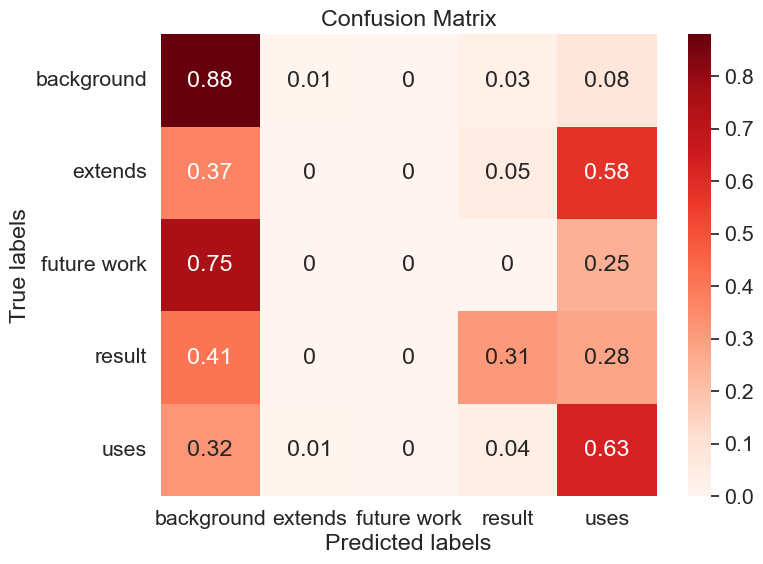

In [47]:
#cm = confusion_matrix(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels, normalize = 'true').round(2)


ticks = np.unique(true_labels)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=ticks, yticklabels=ticks)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()